In [1]:
# -*- coding: utf-8 -*-
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from filterpy.monte_carlo import systematic_resample

In [15]:
# create data

In [16]:
N = 400 # length of time series

theta1 = np.asarray([1.1 + (0.2*(k-200)**2)/(40*10**3) for k in range(N)])
theta2 = np.asarray([-0.3 - (0.1*(k-200)**2)/(40*10**3) for k in range(N)])
    
k = np.arange(N) # time index

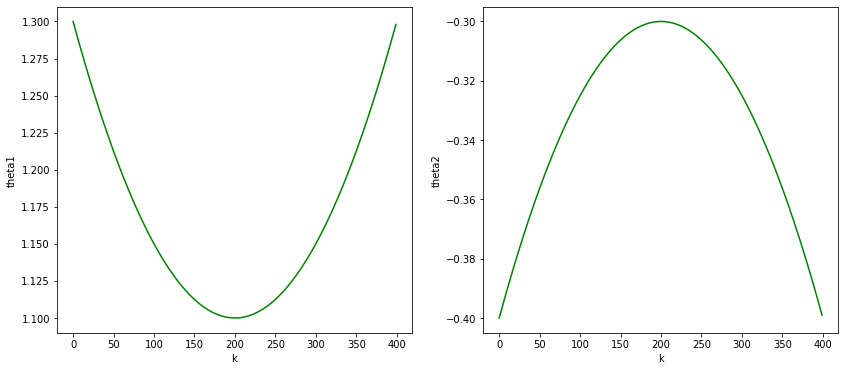

In [17]:
# Plotting time varying parameters
fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)
ax[0].set(xlabel="k", ylabel="theta1")
ax[0].plot(k, theta1, c='g')
ax[1].set(xlabel="k", ylabel="theta2")
ax[1].plot(k, theta2, c='g')
#plt.savefig('theta.jpg')
plt.show()

In [95]:
# Generating underlying 2nd order AR process

# measurement noise
R = 1
np.random.seed(20)
v = np.random.normal(0, R, N) # measurement noise

# measurements
z = np.zeros(N)
z[0], z[1] = 0.1, 0.2 # initial values

for k in range(2,N):
    z[k] = theta1[k]*z[k-1] + theta2[k]*z[k-2] + v[k]
    
k = np.arange(N) # time index

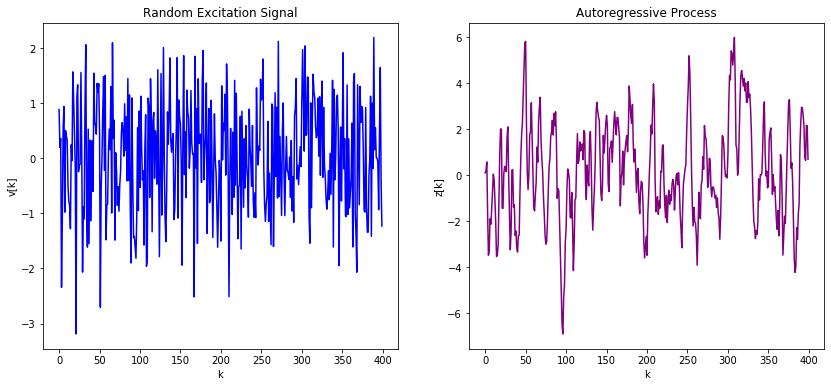

In [96]:
# Plotting time varying synthetic data
fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)
ax[0].set_title("Random Excitation Signal")
ax[0].set(xlabel="k", ylabel="v[k]")
ax[0].plot(k, v, c='b')
ax[1].set_title("Autoregressive Process")
ax[1].set(xlabel="k", ylabel="z[k]")
ax[1].plot(k, z, c='purple')
#plt.savefig('AR_tv.jpg')
plt.show()

In [97]:
# fitting time varying parameters to state space model
from sklearn import linear_model
X1 = np.c_[theta1[0:N-1], theta2[0:N-1]**2]
X2 = np.c_[theta2[0:N-1], theta1[0:N-1]**2]
reg1 = linear_model.Ridge(alpha=10**-3).fit(X1, theta1[1:N])
reg2 = linear_model.Ridge(alpha=10**-3).fit(X2, theta2[1:N])

print("score:", reg1.score(X1, theta1[1:N]))
print("Coeffs:", reg1.coef_)
print("score:", reg2.score(X2, theta2[1:N]))
print("Coeffs:", reg2.coef_)

score: 0.9996096959690731
Coeffs: [0.91405953 0.24780882]
score: 0.9992912184154571
Coeffs: [ 0.17409958 -0.17401076]


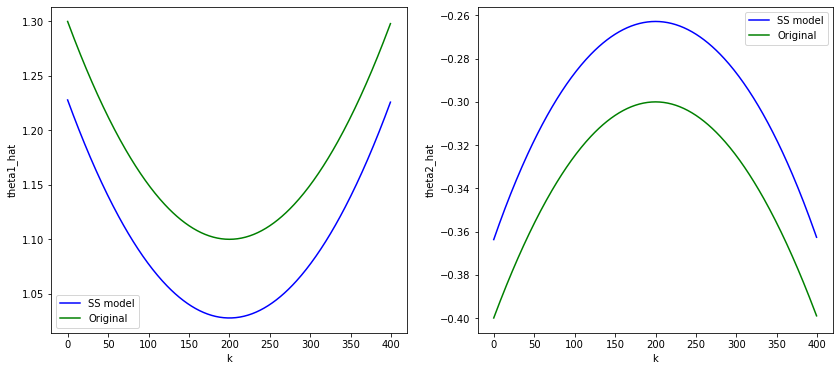

In [98]:
#plot fitted state equations
X1 = np.c_[theta1[0:N], theta2[0:N]**2]
X2 = np.c_[theta2[0:N], theta1[0:N]**2]

fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)
ax[0].set(xlabel="k", ylabel="theta1_hat")
ax[0].plot(k, X1@reg1.coef_, c='b', label='SS model')
ax[1].set(xlabel="k", ylabel="theta2_hat")
ax[1].plot(k, X2@reg2.coef_, c='b', label='SS model')
ax[0].plot(k, theta1, c='g', label='Original')
ax[1].plot(k, theta2, c='g', label='Original')
ax[0].legend()
ax[1].legend()
#plt.savefig('theta.jpg')
plt.show()

In [99]:
# Particle Filter

In [100]:
# here we create a normally distributed set of particles over a region

def create_gauss_particles(N, mu, var):
    """2d normally distributed particles where each sample and dimension is iid"""
    particles = np.empty((N, 2))
    particles[:, 0] = np.random.normal(mu[0], var, N)
    particles[:, 1] = np.random.normal(mu[1], var, N)
    
    return particles

def create_uniform_particles(theta1_range, theta2_range, N):
    particles = np.empty((N, 2))
    particles[:, 0] = np.random.uniform(theta1_range[0], theta1_range[1], size=N)
    particles[:, 1] = np.random.uniform(theta2_range[0], theta2_range[1], size=N)

    return particles

In [101]:
def predict(particles, Q, N):
    """implementation of state equation"""
    particles[:, 0] = 0.91*particles[:, 0] + 0.25*particles[:, 1]**2 + np.random.normal(0, Q, N)
    particles[:, 1] = 0.17*particles[:, 1] - 0.17*particles[:, 0]**2 + np.random.normal(0, Q, N)
    
    return particles

In [102]:
def update(particles, w, z, R):
    
    for i in range(len(particles)):
        #est = np.sqrt((np.dot(particles[i], z[0:2]))**2)
        est = np.dot(particles[i], z[0:2])
        w[i] *= scipy.stats.norm.pdf(z[2], est, R)
        
    w = w + 1.e-300*np.ones(len(w))      # avoid round-off to zero
    w = w/sum(w) # normalize
    
    return w

In [103]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))
    
    return weights

In [104]:
def estimate(particles, w):
    """returns mean and variance of the weighted particles"""
    
    theta = particles
    mean = np.average(theta, weights=w, axis=0)
    var  = np.average((theta - mean)**2, weights=w, axis=0)
    return mean, var

In [105]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [109]:
def pf(N, data):
    
    weights_evol = []
    mu_evol = []
    var_evol = []

    # initial weights
    weights = np.asarray([1/N]*N)
    weights_evol.append(weights.copy())
    
    for k in range(len(z)-2):
    
        # creating N particles normally distributed around initial state
        #particles = create_gauss_particles(N, [1.25, -.36], 1)
        particles = create_uniform_particles([0,3], [-2,1], N)
    
        # predicting particles next state
        particles_next = predict(particles, 10, N)
        
        #updating weights
        weights = update(particles_next, weights.copy(), data[k:k+3], .5)
        #weights_evol.append(weights.copy())
        
        # resample if too few effective particles
        if neff(weights) < 3*N/4:
            indexes = systematic_resample(weights)
            #print(indexes)
            weights = resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        
        #updating weights
        #weights = update(particles_next, weights.copy(), data[k:k+3], .1)
        weights_evol.append(weights.copy())
        
        # estimating state trajectory
        mu, var = estimate(particles_next, weights)
        mu_evol.append(mu)
        var_evol.append(var)
    
    return np.asarray(weights_evol), np.asarray(mu_evol), np.asarray(var_evol)

In [110]:
results = pf(500,z)

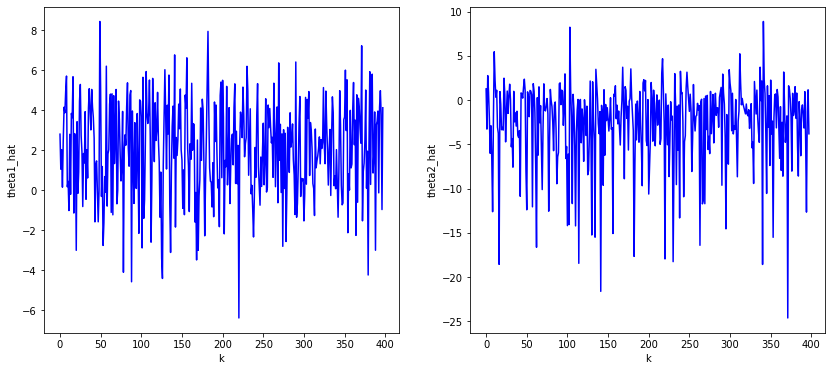

In [111]:
# plotting mean estimated state trajectory
k = np.arange(398) # time index


fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)
ax[0].set(xlabel="k", ylabel="theta1_hat")
ax[0].plot(k, results[1][:,0], c='b')
ax[1].set(xlabel="k", ylabel="theta2_hat")
ax[1].plot(k,  results[1][:,1], c='b')
#plt.savefig('.jpg')
plt.show()

In [83]:
# computing neff
neff_res = []

for k in range(398):
    neff_res.append(neff(results[0][k]))
    
neff_res = np.asarray(neff_res)
k = np.arange(398) # time index

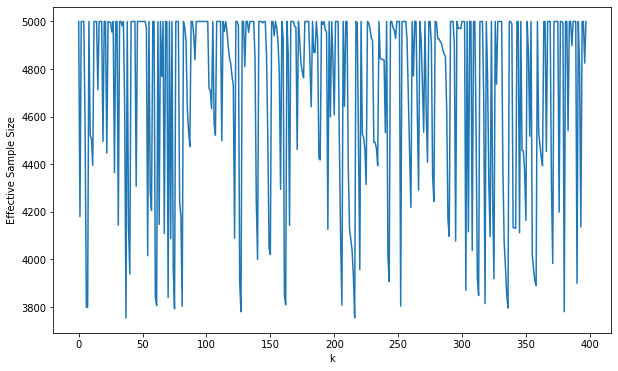

In [84]:
# plotting neff
plt.figure(figsize=(10,6))
plt.plot(k, neff_res)
plt.xlabel('k')
plt.ylabel('Effective Sample Size')
#plt.savefig('.jpg')
plt.show()

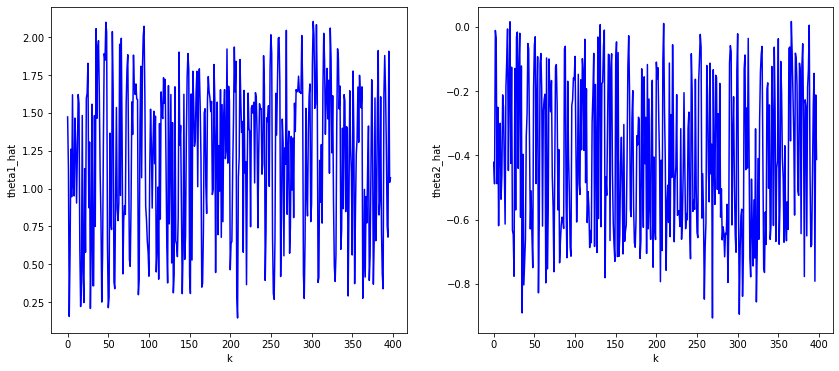